In [1]:
import pandas as pd
uri = "https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv"
dados = pd.read_csv(uri)

mapa = {
    "unfinished": "nao_finalizado",
    "expected_hours": "horas_esperadas",
    "price": "preco"
}

dados.rename(columns = mapa, inplace = True)
dados.head()

,nao_finalizado,horas_esperadas,preco
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


In [2]:
troca = {
    0: 1,
    1: 0
}
dados["finalizado"] = dados.nao_finalizado.map(troca)
dados.tail()

,nao_finalizado,horas_esperadas,preco,finalizado
2152,0,80,7518,1
2153,1,52,1332,0
2154,0,40,473,1
2155,0,75,5324,1
2156,1,37,377,0


In [3]:
import seaborn as sns

sns.scatterplot(x="horas_esperadas", y="preco", data=dados);

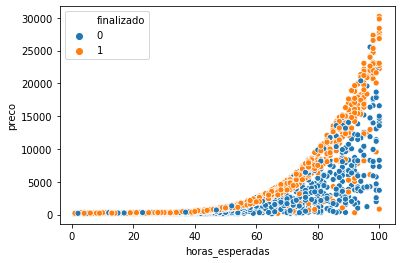

In [4]:
sns.scatterplot(x="horas_esperadas", y="preco", hue="finalizado", data=dados);

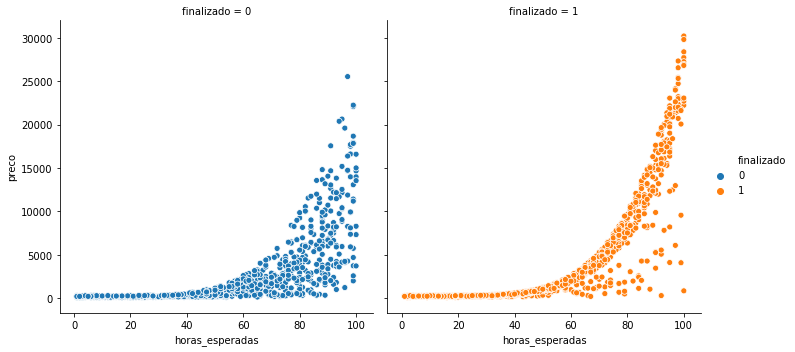

In [5]:
sns.relplot(x="horas_esperadas", y="preco", col="finalizado", hue="finalizado", data=dados);

In [6]:
x = dados[["horas_esperadas","preco"]]
y = dados["finalizado"]

### Primeira tentativa: Algoritmo linear

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np

SEED = 7
np.random.seed(SEED)

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, stratify = y, test_size = 0.25)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos")
modelo = LinearSVC()
modelo.fit(treino_x, treino_y)

previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print(f"A acuracia foi {acuracia:.2f}%")

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acuracia foi 47.41%


/Users/matheus/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Comparamos ao algoritmo de base

In [8]:
import numpy as np
previsoes_de_base = np.ones(540)
acuracia = accuracy_score(teste_y, previsoes_de_base) * 100
print(f"A acuracia do algoritmo de baseline foi {acuracia:.2f}%")

A acuracia do algoritmo de baseline foi 52.59%


**Nosso algorítmo linear tem quase a mesma acurácia que simplemente chutar sim pra todos os testes**

Podemos então perceber que há algo de errado. Vamos então partir para a análise.

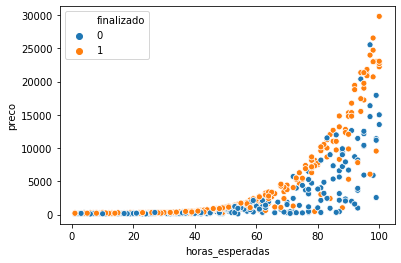

In [9]:
sns.scatterplot(x="horas_esperadas", y="preco", hue=teste_y, data=teste_x);

In [10]:
x_min = teste_x.horas_esperadas.min()
x_max = teste_x.horas_esperadas.max()

y_min = teste_x.preco.min()
y_max = teste_x.preco.max()

print(x_min,x_max,y_min,y_max)


1 100 100 29820


In [11]:
pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

In [12]:
xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]
pontos

array([[1.00000e+00, 1.00000e+02],
       [1.99000e+00, 1.00000e+02],
       [2.98000e+00, 1.00000e+02],
       ...,
       [9.70300e+01, 2.95228e+04],
       [9.80200e+01, 2.95228e+04],
       [9.90100e+01, 2.95228e+04]])

In [13]:
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

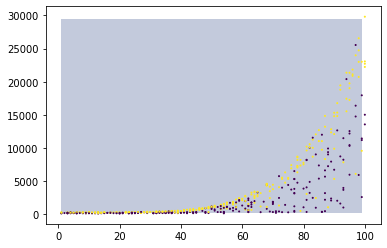

In [14]:
import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=1);

# DECISION BOUNDARY

### Tentando mudar o algorítmo de classificação para o SVC generalizado

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SEED = 7
np.random.seed(SEED)

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, stratify = y, test_size = 0.25)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos")
modelo = SVC()
modelo.fit(treino_x, treino_y)

previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print(f"A acuracia foi {acuracia:.2f}%")

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acuracia foi 59.07%


/Users/matheus/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


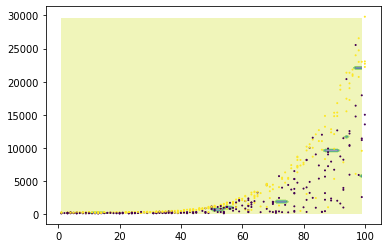

In [21]:
import matplotlib.pyplot as plt
x_min = teste_x.horas_esperadas.min()
x_max = teste_x.horas_esperadas.max()
y_min = teste_x.preco.min()
y_max = teste_x.preco.max()
pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)
xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=1);
# DECISION BOUNDARY

Ainda não atingimos um resultado satisfatorio.
Um dos motivos pode ser a escala dos dados, pois esses algorítmos são muito suscetíveis a isso.
Podemos realizar uma nova tentativa pré-processando os dados.

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SEED = 7
np.random.seed(SEED)

raw_treino_x, raw_teste_x, raw_treino_y, raw_teste_y = train_test_split(x, y, random_state = SEED, stratify = y, test_size = 0.25)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos")

teste_x

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)

previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print(f"A acuracia foi {acuracia:.2f}%")

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acuracia foi 67.59%


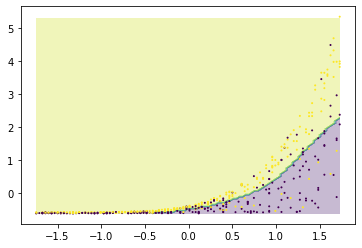

In [46]:
data_x = teste_x[:, 0]
data_y = teste_x[:, 1]

import matplotlib.pyplot as plt
x_min = data_x.min()
x_max = data_x.max()
y_min = data_y.min()
y_max = data_y.max()
pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)
xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(data_x, data_y, c=teste_y, s=1);
# DECISION BOUNDARY